In [1]:
%matplotlib inline
import os,sys,random

from parabola import ParabolicRegion as Parabola
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from igmm import IGMM
from SensorimotorExploration.DataManager.SimulationData import load_sim_h5 as load_sim_h5

In [2]:
def get_random_motor_set(system, n_samples):
    n_motor = system.n_motor
    raw_rnd_data = np.random.random((n_samples, n_motor))

    min_values = system.min_motor_values
    max_values = system.max_motor_values

    min_values = np.array(n_samples * [np.array(min_values)])
    max_values = np.array(n_samples * [np.array(max_values)])
    motor_commands = min_values + raw_rnd_data * (max_values - min_values)
    return motor_commands

# def load_h5(file_name, system=None):
#     # Keeping support to old datamanager files
#     motor = pd.read_hdf(file_name, 'motor').as_matrix()
#     sensor = pd.read_hdf(file_name, 'sensor').as_matrix()
#     return motor, sensor

def evaluate_model(system, model, sensor_evaluation, axes=None):
    if axes is not None:
        plt.sca(axes)
        plt.hold(True)
    n_samples = sensor_evaluation.shape[0]
    x_dims = range(system.n_motor)
    y_dims = range(system.n_motor,system.n_motor+system.n_sensor)
    total_norm_error = 0.
    for i in range(n_samples):
        action = model.infer(x_dims,
                             y_dims,
                            sensor_evaluation[i,:])
        system.set_action(action)
        system.executeMotorCommand()
        if axes is not None:
            plt.scatter(sensor_evaluation[i,0],sensor_evaluation[i,1], marker = 'o', s = 3., color = 'b')
            plt.scatter(system.sensor_out[0],system.sensor_out[1],marker = 'x', s = 12., color = 'r')
        total_norm_error += np.linalg.norm(sensor_evaluation[i,:]-system.sensor_out)
    return total_norm_error/float(n_samples)

In [3]:
batch_size = 15
n_batches = 10

np.random.seed(123)

In [32]:
# Results Container
matplotlib.rcParams['figure.figsize'] = (16.0, 16.0)
matplotlib.rcParams.update({'font.size': 18})
title_font = {'fontname':'Arial', 'size':'16', 'color':'black', 'weight':'normal',
              'verticalalignment':'bottom'} # Bottom vertical alignment for more space
axis_font = {'size':'30'}

# directories = ['experiment_9_ins03/Parabola_Pool_8_2017_03_26_03_21_whole_eva_valset.h5',
#                'experiment_9_ins03/Parabola_Pool_11_2017_03_26_03_22_whole_eva_valset.h5',
#               'experiment_9_ins03/Parabola_Pool_9_2017_03_26_03_21_whole_eva_valset.h5']

directories = ['experiment_9_ins03/Parabola_Pool_16_2017_03_26_03_24_whole_eva_valset.h5',
               'experiment_9_ins03/Parabola_Pool_19_2017_03_26_03_25_whole_eva_valset.h5',
              'experiment_9_ins03/Parabola_Pool_17_2017_03_26_03_25_whole_eva_valset.h5']

eval_data = load_sim_h5('../../Systems/datasets/parabola_dataset_1.h5')

experiment_9_ins03/Parabola_Pool_16_2017_03_26_03_24_whole_eva_valset.h5
0.0914865212581
experiment_9_ins03/Parabola_Pool_19_2017_03_26_03_25_whole_eva_valset.h5
0.13194067643
experiment_9_ins03/Parabola_Pool_17_2017_03_26_03_25_whole_eva_valset.h5
0.0942242491051


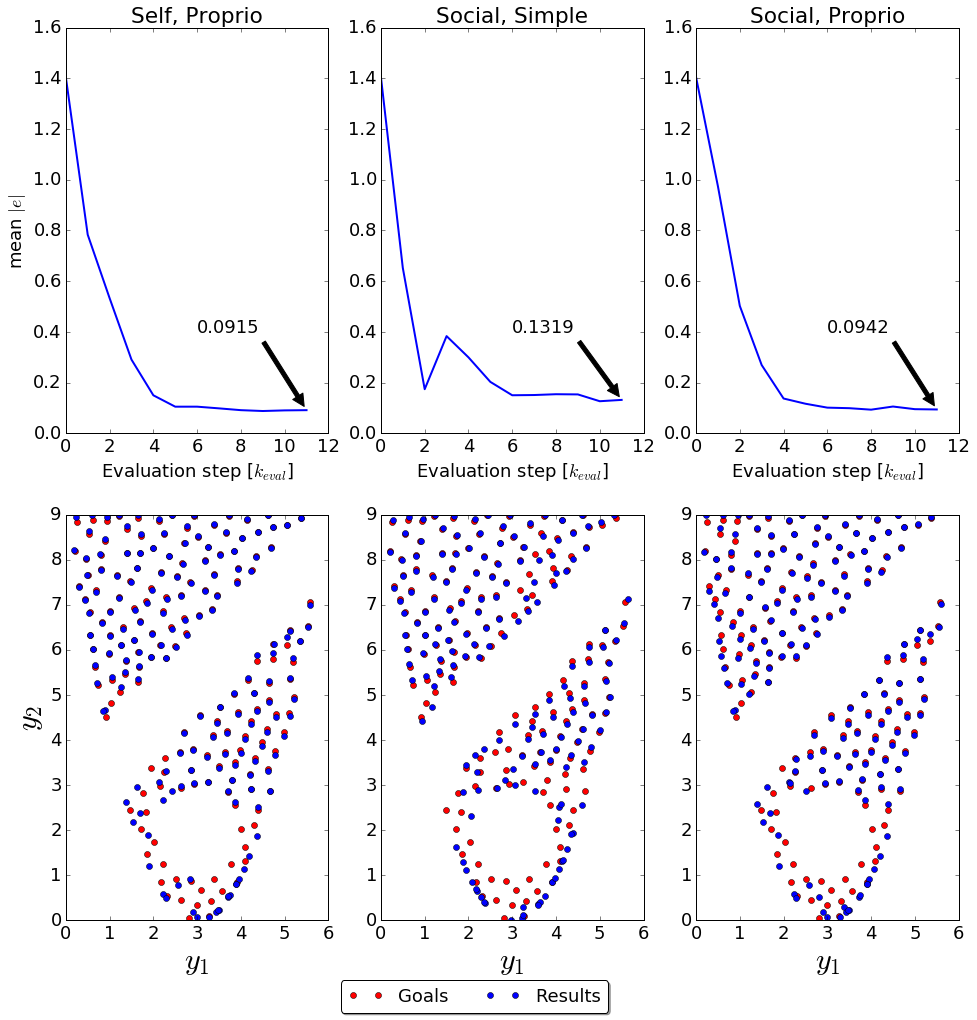

In [34]:
fig1,ax1 = plt.subplots(2,3)

for ii,directory in enumerate(directories):
    ### Train
    print(directory)
    data = load_sim_h5(directory)
    
    sim_eva_errors = []
    with open(directory.replace('whole_eva_valset.h5', 'eval_error.txt'), 'r') as f:
        for line in f:
            line.replace('\n','')
            eva_errors_str = line.split(': ')
            sim_eva_errors += [float(eva_errors_str[1])] 
        
    sim_eva_errors = np.array(sim_eva_errors)
    plt.sca(ax1[0,ii])
    plt.plot(sim_eva_errors, lw=2)
    plt.xlabel('Evaluation step [$k_{eval}$]')
    print(sim_eva_errors[-1])
    
    eval_data.plot_2D('sensor',0,'sensor',1,axes=ax1[1,ii],color='or')
    plt.hold(True)
    data.plot_2D('sensor',0,'sensor',1,axes=ax1[1,ii],color='ob')
    ax1[1,ii].set_xlim([0,6])
    ax1[1,ii].set_ylim([0,9])
    plt.xlabel('$y_1$',**axis_font)

    
plt.sca(ax1[0,0])
plt.ylabel('mean $|e|$')
plt.title('Self, Proprio')

plt.sca(ax1[0,1])
plt.title('Social, Simple')

plt.sca(ax1[0,2])
plt.title('Social, Proprio')

plt.sca(ax1[1,0])
plt.ylabel('$y_2$',**axis_font)

lgd = plt.legend(['Goals','Results'],\
                 ncol=2,loc='lower right', fontsize=18, bbox_to_anchor=(2.1, -0.25),
                 fancybox=True, shadow=True)
# fig1.tight_layout(h_pad=0.5)

ax1[0,0].annotate('0.0915', xy=(11, 0.0915), xytext=(6, 0.4),
            arrowprops=dict(facecolor='black', shrink=0.05))
ax1[0,1].annotate('0.1319', xy=(11, 0.1319), xytext=(6, 0.4),
            arrowprops=dict(facecolor='black', shrink=0.05))
ax1[0,2].annotate('0.0942', xy=(11, 0.0942), xytext=(6, 0.4),
            arrowprops=dict(facecolor='black', shrink=0.05))

experiment_9_ins03/Parabola_Pool_16_2017_03_26_03_24_social_eva_valset.h5
0.155332597518
experiment_9_ins03/Parabola_Pool_19_2017_03_26_03_25_social_eva_valset.h5
0.219113191397
experiment_9_ins03/Parabola_Pool_17_2017_03_26_03_25_social_eva_valset.h5
0.125107148041


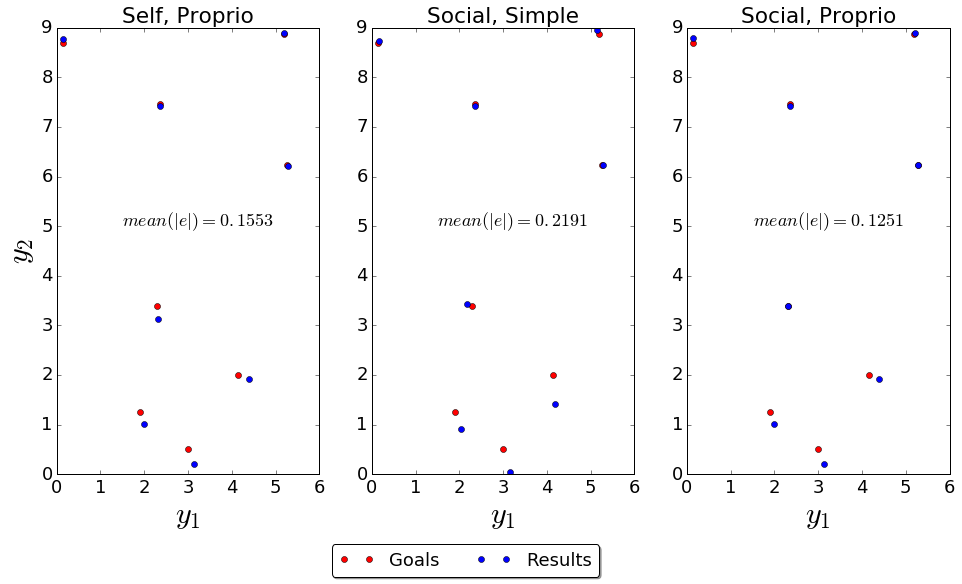

In [47]:
matplotlib.rcParams['figure.figsize'] = (16.0, 8.0)
matplotlib.rcParams.update({'font.size': 18})
directories = [
               'experiment_9_ins03/Parabola_Pool_16_2017_03_26_03_24_social_eva_valset.h5',
               'experiment_9_ins03/Parabola_Pool_19_2017_03_26_03_25_social_eva_valset.h5',
               'experiment_9_ins03/Parabola_Pool_17_2017_03_26_03_25_social_eva_valset.h5']

fig1,ax1 = plt.subplots(1,3)

for ii,directory in enumerate(directories):
    ### Train
    print(directory)
    data = load_sim_h5(directory)
    
    sim_eva_errors = []
        
    data.plot_2D('sensor_goal',0,'sensor_goal',1,axes=ax1[ii],color='or')
    plt.hold(True)
    data.plot_2D('sensor',0,'sensor',1,axes=ax1[ii],color='ob')
    ax1[ii].set_xlim([0,6])
    ax1[ii].set_ylim([0,9])
    plt.xlabel('$y_1$',**axis_font)
    sim_sensor_error_ = np.linalg.norm(data.sensor_goal.data.as_matrix() -
                                  data.sensor.data.as_matrix(), axis=1)
    print(np.mean(sim_sensor_error_))
    
plt.sca(ax1[0])
plt.ylabel('mean $|e|$')
plt.title('Self, Proprio')

plt.sca(ax1[1])
plt.title('Social, Simple')

plt.sca(ax1[2])
plt.title('Social, Proprio')

plt.sca(ax1[0])
plt.ylabel('$y_2$',**axis_font)

lgd = plt.legend(['Goals','Results'],\
                 ncol=2,loc='lower right', fontsize=18, bbox_to_anchor=(2.1, -0.25),
                 fancybox=True, shadow=True)
# fig1.tight_layout(h_pad=0.5)

ax1[0].text(1.5, 5, r'$mean(|e|)=0.1553$', fontsize=18)
ax1[1].text(1.5, 5, r'$mean(|e|)=0.2191$', fontsize=18)
ax1[2].text(1.5, 5, r'$mean(|e|)=0.1251$', fontsize=18)

In [48]:
fig1.savefig('/home/yumilceh/Desktop/Parabola_eval_social.eps',\
             format='eps', dpi=1000, transparent=True, bbox_extra_artists=(lgd,), bbox_inches='tight')